### Install required libraries

In [1]:
! pip install hazm
! pip install gensim
! pip -q install clean-text[gpl]
! pip install pandas
! pip install arabic_reshaper
! pip install python-bidi
! pip install seaborn
! pip install parsivar
! pip install stanza
!pip install -q findspark

  Using cached nltk-3.3-py3-none-any.whl
  Attempting uninstall: nltk
    Found existing installation: nltk 3.4.5
    Uninstalling nltk-3.4.5:
      Successfully uninstalled nltk-3.4.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
parsivar 0.2.3 requires nltk==3.4.5, but you have nltk 3.3 which is incompatible.
  Using cached nltk-3.4.5-py3-none-any.whl
  Attempting uninstall: nltk
    Found existing installation: nltk 3.3
    Uninstalling nltk-3.3:
      Successfully uninstalled nltk-3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
hazm 0.7.0 requires nltk==3.3, but you have nltk 3.4.5 which is incompatible.


In [2]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
get_ipython().system_raw('./ngrok http 4050 &')

--2021-12-13 13:36:54--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 18.205.222.128, 52.202.168.65, 54.161.241.46, ...
Connecting to bin.equinox.io (bin.equinox.io)|18.205.222.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13832437 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.1’

ngrok-stable-linux- 100%[===================>]  13.19M  3.34MB/s    in 5.0s    

2021-12-13 13:36:59 (2.66 MB/s) - ‘ngrok-stable-linux-amd64.zip.1’ saved [13832437/13832437]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ngrok                   


### Install Open JDK for Spark and Hadoop

In [3]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz
!tar xf spark-3.2.0-bin-hadoop3.2.tgz

### Download Masnavi corpus to work on

In [4]:
!wget https://raw.githubusercontent.com/SajjadMb/Masnavi_NLP_Toolkit/main/masnavi.txt?token=AF4HC2VV75CFQKTTASY7GXDBX5N2Y
!mv masnavi.txt?token=AF4HC2VV75CFQKTTASY7GXDBX5N2Y masnavi.txt

--2021-12-13 13:38:26--  https://raw.githubusercontent.com/SajjadMb/Masnavi_NLP_Toolkit/main/masnavi.txt?token=AF4HC2VV75CFQKTTASY7GXDBX5N2Y
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3090459 (2.9M) [text/plain]
Saving to: ‘masnavi.txt?token=AF4HC2VV75CFQKTTASY7GXDBX5N2Y’

masnavi.txt?token=A 100%[===================>]   2.95M  --.-KB/s    in 0.05s   

2021-12-13 13:38:27 (55.1 MB/s) - ‘masnavi.txt?token=AF4HC2VV75CFQKTTASY7GXDBX5N2Y’ saved [3090459/3090459]



### Download Stopwords (I added some necessary stop words after studying the corpus)

In [5]:
!wget https://raw.githubusercontent.com/SajjadMb/Masnavi_NLP_Toolkit/main/stopwords.txt?token=AF4HC2UWVYPTWNSXDWDW6RTBX5OMU
!mv stopwords.txt?token=AF4HC2UWVYPTWNSXDWDW6RTBX5OMU stopwords.txt

--2021-12-13 13:38:27--  https://raw.githubusercontent.com/SajjadMb/Masnavi_NLP_Toolkit/main/stopwords.txt?token=AF4HC2UWVYPTWNSXDWDW6RTBX5OMU
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15569 (15K) [text/plain]
Saving to: ‘stopwords.txt?token=AF4HC2UWVYPTWNSXDWDW6RTBX5OMU’

stopwords.txt?token 100%[===================>]  15.20K  --.-KB/s    in 0s      

2021-12-13 13:38:27 (74.5 MB/s) - ‘stopwords.txt?token=AF4HC2UWVYPTWNSXDWDW6RTBX5OMU’ saved [15569/15569]



### Import Libraries

In [6]:
import pandas as pd
import numpy as np
import re
from __future__ import unicode_literals
import hazm
import nltk
import codecs
import tqdm
import gensim
from cleantext import clean

### Plot Utils
following function is responsible for plotting top 8 common categories resulting from LDA and NMF algorithms

In [7]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

### Label Persian Compatibility
following functions are needed to print persian labels on plot in right to left direction

In [8]:
from arabic_reshaper import reshape
from bidi.algorithm import get_display
import seaborn as sns

In [9]:
def make_farsi_text(x):
    if x == 'الله':
        return 'هللا'
    reshaped_text = reshape(x)
    farsi_text = get_display(reshaped_text)
    return farsi_text

### Load DataSet from `masnavi.txt`

In [10]:
with open('masnavi.txt', 'r', encoding="utf8") as infile:
    masnavi_file = infile.readlines()

### Load Stopwords from `stopwords.txt`

In [11]:
stopwords = [x.strip() for x in codecs.open('stopwords.txt','r','utf-8').readlines()]

### Instantiate Hazm Normalizer into `normalizer` variable

In [12]:
normalizer = hazm.Normalizer()

In [13]:
normalizer.normalize('آتشی عشق کاندر نی فتاد')

'آتشی عشق کاندر نی فتاد'

### Instantiate Hazm Lemmatizer into `lemmatizer` variable

In [14]:
lemmatizer = hazm.Lemmatizer()

In [15]:
lemmatizer.lemmatize('آتشی عشق کاندر نی فتاد')

'آتشی عشق کاندر نی فتاد'

### Remove Space patterns regex
The following function returns regex appropriate to omit unwanted spaces in text.

In [16]:
def remove_spaces_reg():
    # return space patterns
    space_pattern = r"[\xad\ufeff\u200e\u200d\u200b\x7f\u202a\u2003\xa0\u206e\u200c\x9d]"
    return re.compile(space_pattern)

### Remove Symbols and Punctuation patterns regex
The following function returns regex appropriate to omit unwanted symbols and punctuations in text.

In [17]:
def remove_symbols_reg():
    # return symbol patterns
    symbol_patterns = r"(\d|\"|'ٍ|¬|[؛“،,”‘۔’’‘–]|[|\.÷+\:\-\?»\=\{}\*«»_…\؟!/ـ]|[۰'ٓ۫'ٔ]|[ٓٔ]|[ًٌٍْﹼ،َُِّ«ٰ»ٖء])"
    return re.compile(symbol_patterns)

### Convert Arabic alphabet to persian alphabet
The following function converts the Arabic alphabet in text into the corresponding Persian one.

In [18]:
def remeove_arabic(text):
    # remove arabic alphabet
    mapping = {
        u"ۀ" : u"ه",
        u"ة" : u"ت",
        u"ي" : u"ی",
        u"ؤ" : u"و",
        u"إ" : u"ا",
        u"ٹ" : u"ت",
        u"ڈ" : u"د",
        u"ئ" : u"ی",
        u"ﻨ" : u"ن",
        u"ﺠ" : u"ج",
        u"ﻣ" : u"م",
        u"ﷲ" : u"",
        u"ﻳ" : u"ی",
        u"ٻ" : u"ب",
        u"ٱ" : u"ا",
        u"ڵ" : u"ل",
        u"ﭘ" : u"پ",
        u"ﻪ" : u"ه",
        u"ﻳ" : u"ی",
        u"ٻ" : u"ب",
        u"ں" : u"ن",
        u"ٶ" : u"و",
        u"ٲ" : u"ا",
        u"ہ" : u"ه",
        u"ﻩ" : u"ه",
        u"ﻩ" : u"ه",
        u"ك" : u"ک",
        u"ﺆ" : u"و",
        u"أ" : u"ا",
        u"ﺪ" : u"د"
    }

    arabic_keys =  re.compile(r"(" + "|".join(mapping.keys()) + r")")
    return arabic_keys.sub(lambda x: mapping[x.group()], text)

### Create needed regexes

In [19]:
spaces_reg = remove_spaces_reg() 
symbols_reg = remove_symbols_reg()

### clean_text function
the following method cleans input text from extra spaces, stop words, punctuations, unwanted symbols and arabic alphabet.

In [20]:
def clean_text(text):
    text = re.sub(spaces_reg, " ", text)
    text = re.sub(symbols_reg, "", text)
    text = remeove_arabic(text)
    text = normalizer.normalize(text)
    regex = r"\b(?:" + "|".join(map(re.escape, stopwords)) + r")\b"
    text = re.sub(regex, " ", text)
    text = re.sub(spaces_reg, " ", text)
    text = re.sub("(\s)+", " ", text)
    text = text.strip()
    return text

### Process Couplet(Beyt)
The following code :
- checks whether the line is Couplet or not
- if the line is couplet extract Poem Number and Couplet number
- Extract Hemistich(Mesra)

In [21]:
def process_couplet(text):
    result = re.search("(\d{1,3})\.(\d{1,3})", text)
    # check if line contains a couplet
    if result:
        pno, cno = result.groups()
        # delete Daftar and Poem number
        couplet = re.sub("(\d{1,3})\.(\d{1,3})", "", text)
        # extract mesra
        hemistich = couplet.split("\t")[1:3]
        # extract important tokens in mesra
        cleaned_hemistich = [clean_text(h) for h in hemistich]
        # clean spaces
        couplet = re.sub(spaces_reg, " ", couplet)
        return pno, cno, couplet, " ".join(cleaned_hemistich), cleaned_hemistich[0], cleaned_hemistich[1]
    return None

#### Example 1

In [22]:
process_couplet('1.10	آتش ِعشق است كاندر نی فتاد	جوشش عشق است كاندر می   فتاد')

('1',
 '10',
 '\tآتش ِعشق است كاندر نی فتاد\tجوشش عشق است كاندر می   فتاد',
 'آتش عشق نی فتاد جوشش عشق فتاد',
 'آتش عشق نی فتاد',
 'جوشش عشق فتاد')

#### Example 2

In [23]:
process_couplet('28.16	قطره ای از باده های آسمان	پُر كند جان را ز می و ز ساقیان ')

('28',
 '16',
 '\tقطره ای از باده های آسمان\tپُر كند جان را ز می و ز ساقیان ',
 'قطره باده آسمان ساقیان',
 'قطره باده آسمان',
 'ساقیان')

#### Example 3

In [24]:
process_couplet('10.14	گر نبودی كارش الهام اله	او سگی بودی دراننده، نه شاه')

('10',
 '14',
 '\tگر نبودی كارش الهام اله\tاو سگی بودی دراننده، نه شاه',
 'نبودی کارش الهام اله سگی دراننده شاه',
 'نبودی کارش الهام اله',
 'سگی دراننده شاه')

#### Array Masnavi Contains all couplets process by function `process_couplet`

In [25]:
masnavi = []

### Process Dataset and append all couplets to masnavi list

In [26]:
daftar = 0
for couplet in masnavi_file:
    if re.search("^(?:دفتر).*.(?:مثنوی)$", couplet):
        daftar += 1
        if daftar == 7:
            print("Processing Completed!")
            break
        print(f"Processing Daftar {daftar}")
    else:
        process_result = process_couplet(couplet)
        if process_result:
            pno = process_result[0]
            cno = process_result[1]
            c = process_result[2]
            cc = process_result[3]
            h1 = process_result[4]
            h2 = process_result[5]
            data = (daftar, pno, cno, c, cc, h1, h2)
            masnavi.append(data)

Processing Daftar 1
Processing Daftar 2
Processing Daftar 3
Processing Daftar 4
Processing Daftar 5
Processing Daftar 6


### Convert `masnavi` list to `masnavi_df` pandas dataframe

In [27]:
masnavi_df = pd.DataFrame(masnavi, columns=['Daftar', 'Poem', 'CNo', 'Couplet', 'CCouplet', 'Hemistich1', 'Hemistich2'])

### Convert dataframe Daftar Poem and Couplet Number to Numeric

In [28]:
masnavi_df['Daftar'] = masnavi_df['Daftar'].apply(pd.to_numeric)
masnavi_df['Poem'] = masnavi_df['Poem'].apply(pd.to_numeric)
masnavi_df['CNo'] = masnavi_df['CNo'].apply(pd.to_numeric)

### Create Tokenized columns

In [29]:
masnavi_df['Couplet_tokenized'] = masnavi_df['CCouplet'].apply(lambda x:hazm.word_tokenize(x))

In [30]:
masnavi_df['Hemistich1_tokenized'] =  masnavi_df['Hemistich1'].apply(lambda x:hazm.word_tokenize(x))

In [31]:
masnavi_df['Hemistich2_tokenized'] =  masnavi_df['Hemistich2'].apply(lambda x:hazm.word_tokenize(x))

## Pos Tagger

### First I tried parsivar with stanford tagger model

In [32]:
from parsivar import Tokenizer, FindStems, FindChunks, POSTagger

pars_tokenizer = Tokenizer()
pars_tagger = POSTagger(tagging_model="stanford")

#### create Pos Tag with Parsivar Tagger

In [33]:
def create_pos_tag(text):
    # pos tag couplet
    return pars_tagger.parse(pars_tokenizer.tokenize_words(text))

#### As you see Results aren't satisfying
Moreover, It's too slow and cannot be apply on whole dataset.

#### Example 1)

In [34]:
create_pos_tag('نبودی کارش الهام اله سگی دراننده شاه')

[('نبودی', 'N'),
 ('کارش', 'N'),
 ('الهام', 'N'),
 ('اله', 'AR'),
 ('سگی', 'N'),
 ('دراننده', 'N'),
 ('شاه', 'N')]

#### Example 2)

In [35]:
create_pos_tag('آتش عشق نی فتاد جوشش عشق فتاد')

[('آتش', 'N'),
 ('عشق', 'N'),
 ('نی', 'N'),
 ('فتاد', 'DELM'),
 ('جوشش', 'N'),
 ('عشق', 'N'),
 ('فتاد', 'V_PA')]

### Welcome to Spark
I saw the process of post tagging is too time-consuming and the python wrapper implemented by Parsivar is not appropriate to feed into user-defined function because it uses pointers that cannot be pickled at spark runtime process.

### First We need to fix environment variables

In [36]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.0-bin-hadoop3.2"

### Then we use `Findspark` to find spark executable

In [37]:
import findspark
findspark.init()
findspark.find()

'/content/spark-3.2.0-bin-hadoop3.2'

### Create Spark Session

In [38]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

### Import Spark Context and import other necessary utils

In [39]:
from pyspark.sql import SQLContext
from pyspark import SparkContext
from pyspark.sql.functions import udf, col

### Instanciate `sqlContext` and create spark dataframe from masnavi pandas dataframe

In [40]:
sqlContext = SQLContext(spark)
masnavi_pdf = sqlContext.createDataFrame(masnavi_df)

/content/spark-3.2.0-bin-hadoop3.2/python/pyspark/sql/context.py:79: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


### Print Spark Dataframe Schema

In [41]:
masnavi_pdf.printSchema()

root
 |-- Daftar: long (nullable = true)
 |-- Poem: long (nullable = true)
 |-- CNo: long (nullable = true)
 |-- Couplet: string (nullable = true)
 |-- CCouplet: string (nullable = true)
 |-- Hemistich1: string (nullable = true)
 |-- Hemistich2: string (nullable = true)
 |-- Couplet_tokenized: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- Hemistich1_tokenized: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- Hemistich2_tokenized: array (nullable = true)
 |    |-- element: string (containsNull = true)



### Tokenization Using Parsivar and Spark


In [42]:
from pyspark.sql.types import ArrayType, StringType

In [43]:
token_udf = udf(
    lambda couplet: pars_tokenizer.tokenize_words(couplet),
    StringType())  

In [44]:
 masnavi_pdf = masnavi_pdf.withColumn("ParsTokens", token_udf(masnavi_pdf.Couplet))

#### Convert pyspark dataframe to pandas dataframe

In [45]:
masnavi_df = masnavi_pdf.toPandas()

#### store result into `masnavi_df.csv` file

In [46]:
masnavi_df.to_csv('masnavi_df.csv', encoding='utf-8')

### Stanza Library and Spark

#### Download persian model

In [47]:
import stanza
stanza.download('fa')

2021-12-13 13:40:12 INFO: Downloading default packages for language: fa (Persian)...
2021-12-13 13:40:12 INFO: File exists: /root/stanza_resources/fa/default.zip.
2021-12-13 13:40:15 INFO: Finished downloading models and saved to /root/stanza_resources.


### Create Processing Pipline

In [48]:
nlp = stanza.Pipeline(lang='fa', processors='tokenize,mwt,pos')

2021-12-13 13:40:15 INFO: Loading these models for language: fa (Persian):
| Processor | Package |
-----------------------
| tokenize  | perdt   |
| mwt       | perdt   |
| pos       | perdt   |

2021-12-13 13:40:15 INFO: Use device: cpu
2021-12-13 13:40:15 INFO: Loading: tokenize
2021-12-13 13:40:15 INFO: Loading: mwt
2021-12-13 13:40:15 INFO: Loading: pos
2021-12-13 13:40:15 INFO: Done loading processors!


### Execute Stanford model on Masnavi Data using Pyspark

I reduced the needed time to parse masnavi corpus from 10 hours to 20 minutes; however, if your want to run it yourself, you need to wait for 20 minutes too.

### Extract Pos tags without cleaning

In [49]:
pos_tags_without_cleaning = masnavi_pdf.select("Couplet").rdd.map(lambda x: nlp(x[0])).collect()

### Extract Pos tags with custom cleaning

In [50]:
pos_tags_with_cleaning = masnavi_pdf.select("Couplet").rdd.map(lambda x: nlp(clean_text(x[0]))).collect()

#### Number of pos sentences

In [51]:
len(pos_tags_with_cleaning)

27953

### PosTag Class
the following class keeps tags data about each word in corpus

In [52]:
class PosTag:
  def __init__(self, id, text, upos, xpos, feats, start_char, end_char):
    self.id = id
    self.text = text
    self.upos = upos
    self.xpos = xpos
    self.feats = {x.split("=")[0]:x.split("=")[1] for x in [x for x in feats.split("|")]} if feats else {}
    self.start_char = start_char
    self.end_char = end_char

  def to_dict(self):
    return {
        'id': self.id,
        'text': self.text,
        'upos': self.upos,
        'xpos': self.xpos,
        'feats': self.feats,
        'start_char': self.start_char,
        'end_char': self.end_char
    }

### Create `masnavi_tags` containing `PosTag` class objects

In [54]:
class MasnaviPosBasedAnalyze:
  def __init__(self, pos_tags):
    self.masnavi_tags = list()
    for i, tags in enumerate(pos_tags):
      try:
        sent = tags.sentences[0]
        for word in sent.words:
          self.masnavi_tags.append(PosTag(
              i,
              word.text, 
              word.upos, 
              word.xpos, 
              word.feats, 
              word.start_char, 
              word.end_char))
      except:
        pass
    self.masnavi_pos_df = pd.DataFrame.from_records([t.to_dict() for t in self.masnavi_tags])

  def common_adjectives(self, count=50):
    return nltk.FreqDist(self.masnavi_pos_df[self.masnavi_pos_df["upos"]=="ADJ"]["text"]).most_common(count)

  def common_nouns(self, count=50):
    return nltk.FreqDist(self.masnavi_pos_df[self.masnavi_pos_df["upos"]=="NOUN"]["text"]).most_common(50)

  def common_verbs(self, count=50):
    return nltk.FreqDist(self.masnavi_pos_df[self.masnavi_pos_df["upos"]=="VERB"]["text"]).most_common(50)

In [55]:
analyzer = MasnaviPosBasedAnalyze(pos_tags=pos_tags_with_cleaning)

### Most Common Adjectives in **Masnavi**

In [56]:
analyzer.common_adjectives()

[('پنهان', 218),
 ('نیک', 218),
 ('پاک', 206),
 ('مست', 199),
 ('نهان', 187),
 ('کور', 174),
 ('زنده', 159),
 ('زشت', 150),
 ('بدی', 142),
 ('بسته', 140),
 ('روان', 138),
 ('پدید', 130),
 ('مرده', 129),
 ('نو', 124),
 ('پیر', 123),
 ('عاشق', 122),
 ('خرد', 112),
 ('شاد', 111),
 ('کژ', 110),
 ('خشک', 106),
 ('گم', 104),
 ('عیان', 102),
 ('دراز', 100),
 ('دور', 98),
 ('خام', 94),
 ('روشن', 90),
 ('خفته', 87),
 ('تیز', 87),
 ('پاره', 86),
 ('نیکو', 85),
 ('زار', 84),
 ('تنگ', 83),
 ('خوار', 82),
 ('خاص', 80),
 ('صاحب', 80),
 ('خور', 80),
 ('گرم', 79),
 ('عام', 78),
 ('حیران', 73),
 ('تلخ', 72),
 ('زرد', 72),
 ('سرد', 72),
 ('گران', 72),
 ('جفت', 71),
 ('اندک', 70),
 ('ایمن', 69),
 ('سست', 69),
 ('سیر', 68),
 ('ویران', 68),
 ('افزون', 67)]

### Most Common Nouns in **Masnavi**

In [57]:
analyzer.common_nouns()

[('دل', 1148),
 ('آب', 941),
 ('دست', 814),
 ('نی', 808),
 ('چشم', 798),
 ('نور', 640),
 ('عقل', 593),
 ('تن', 501),
 ('کار', 468),
 ('خدا', 449),
 ('ره', 412),
 ('جهان', 409),
 ('شب', 399),
 ('شیر', 395),
 ('خاک', 386),
 ('مرد', 381),
 ('آتش', 380),
 ('عشق', 375),
 ('زن', 370),
 ('خانه', 355),
 ('شاه', 350),
 ('خلق', 328),
 ('گوش', 323),
 ('سخن', 322),
 ('گل', 317),
 ('نفس', 309),
 ('درد', 303),
 ('الله', 298),
 ('زر', 296),
 ('زمین', 286),
 ('وقت', 281),
 ('یار', 280),
 ('بانگ', 279),
 ('خواب', 276),
 ('غم', 267),
 ('خون', 254),
 ('شکر', 243),
 ('خر', 233),
 ('دین', 233),
 ('پا', 232),
 ('بحر', 228),
 ('آفتاب', 226),
 ('نان', 226),
 ('مرگ', 225),
 ('شه', 220),
 ('مرغ', 219),
 ('ملک', 218),
 ('بینی', 214),
 ('عالم', 213),
 ('خیال', 210)]

### Most Common Verbs in **Masnavi**

In [58]:
analyzer.common_verbs()

[('خورد', 187),
 ('بیند', 183),
 ('کشد', 144),
 ('داند', 143),
 ('نمود', 118),
 ('ببین', 117),
 ('کشید', 116),
 ('رسد', 116),
 ('میشود', 115),
 ('نهد', 109),
 ('نگردد', 107),
 ('میرود', 105),
 ('ناید', 102),
 ('خواند', 95),
 ('شه', 90),
 ('دیدی', 89),
 ('ندید', 87),
 ('ببینی', 86),
 ('بشنو', 83),
 ('بدید', 81),
 ('شنید', 79),
 ('بنگر', 77),
 ('بدانی', 75),
 ('نبیند', 72),
 ('فتاد', 71),
 ('نهاد', 71),
 ('نداند', 71),
 ('افتاد', 71),
 ('ببیند', 69),
 ('میزند', 68),
 ('نیاید', 65),
 ('گشتی', 65),
 ('آمدی', 65),
 ('میکرد', 62),
 ('شدست', 62),
 ('بگفت', 60),
 ('میرسد', 60),
 ('افتد', 59),
 ('میدهد', 59),
 ('بگذار', 58),
 ('میگفت', 58),
 ('برده', 58),
 ('دیدم', 58),
 ('فرمود', 57),
 ('بجو', 57),
 ('بده', 55),
 ('بری', 55),
 ('ربود', 54),
 ('توست', 54),
 ('مرد', 54)]

### Frequency Analysis

In [59]:
from itertools import chain
from collections import Counter

In [60]:
all_words = list(chain.from_iterable(masnavi_df.Couplet_tokenized))

In [61]:
words_frequencies = nltk.FreqDist(all_words).most_common(100)

In [62]:
words_frequencies[:10]

[('دل', 1047),
 ('آب', 941),
 ('نی', 911),
 ('دست', 776),
 ('چشم', 731),
 ('نور', 648),
 ('جهان', 602),
 ('عقل', 565),
 ('تن', 495),
 ('کار', 451)]

In [63]:
print ('%-16s' % 'Number of words', '%-16s' % len(all_words))
print ('%-16s' % 'Number of unique words', '%-16s' % len(set(all_words)))
avg=np.sum([len(word) for word in all_words])/len(all_words)
print ('%-16s' % 'Average word length', '%-16s' % avg)
print ('%-16s' % 'Longest word', '%-16s' % all_words[np.argmax([len(word) for word in all_words])])

Number of words  162712          
Number of unique words 22055           
Average word length 4.006084369929692
Longest word     استخوانهاشان    


### TF/IDF Analysis

In [64]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import matplotlib.pyplot as plt

In [65]:
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95, min_df=2, max_features=10000
)

In [66]:
tfidf = tfidf_vectorizer.fit_transform(all_words)

In [67]:
tfidf

<162712x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 148999 stored elements in Compressed Sparse Row format>

In [68]:
tf_vectorizer = CountVectorizer(
    max_df=0.95, min_df=2, max_features=10000
)

In [69]:
tf = tf_vectorizer.fit_transform(all_words)

In [70]:
nmf = NMF(
    n_components=10,
    random_state=1,
    beta_loss="kullback-leibler",
    solver="mu",
    max_iter=1000,
    alpha_W=0.1,
    alpha_H=0.1,
    l1_ratio=0.5,
)

In [71]:
W = nmf.fit_transform(tfidf)

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


In [72]:
H = nmf.components_

In [73]:
H.shape

(10, 10000)

In [74]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

In [75]:
tfidf_feature_names = [make_farsi_text(t) for t in tfidf_feature_names]

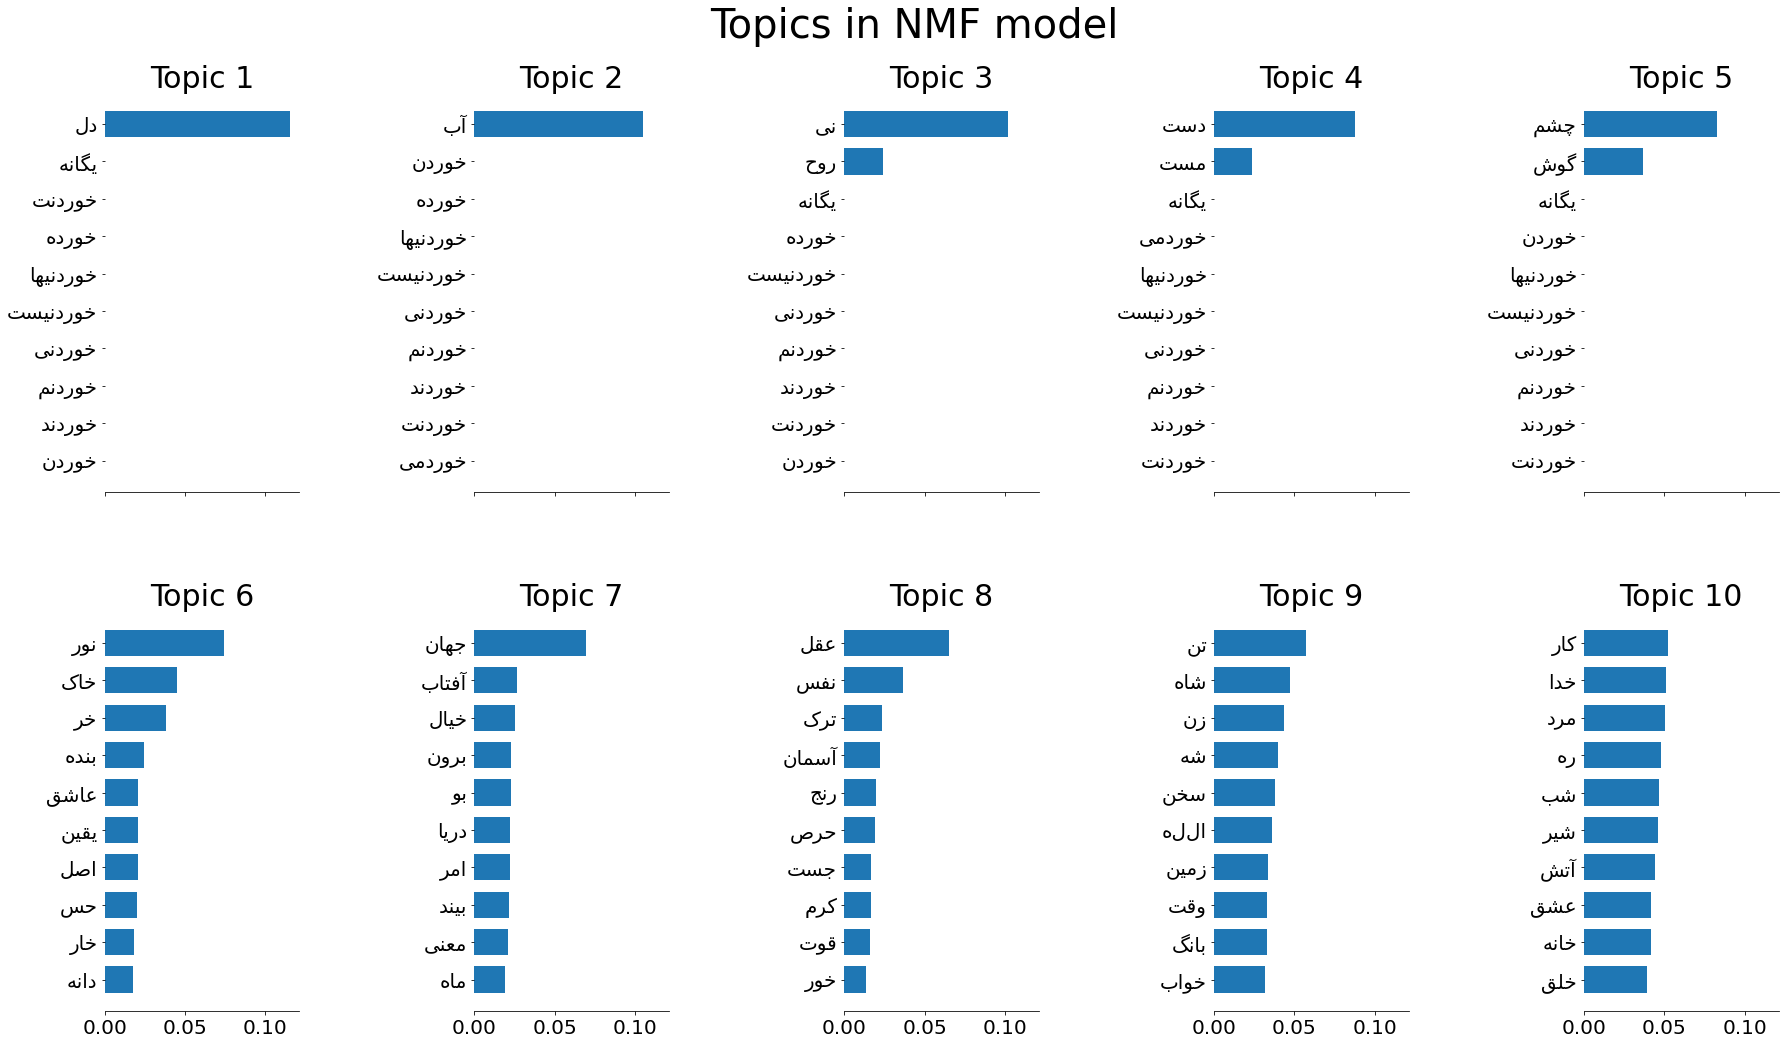

In [76]:
plot_top_words(
    nmf,
    tfidf_feature_names,
    10,
    "Topics in NMF model",
)

In [77]:
lda = LatentDirichletAllocation(
    n_components=10,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)

In [78]:
lda.fit(tf)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, random_state=0)

In [79]:
tf_feature_names = tf_vectorizer.get_feature_names_out()

In [80]:
tf_feature_names = [make_farsi_text(t) for t in tf_feature_names]

In [81]:
top_words = 10

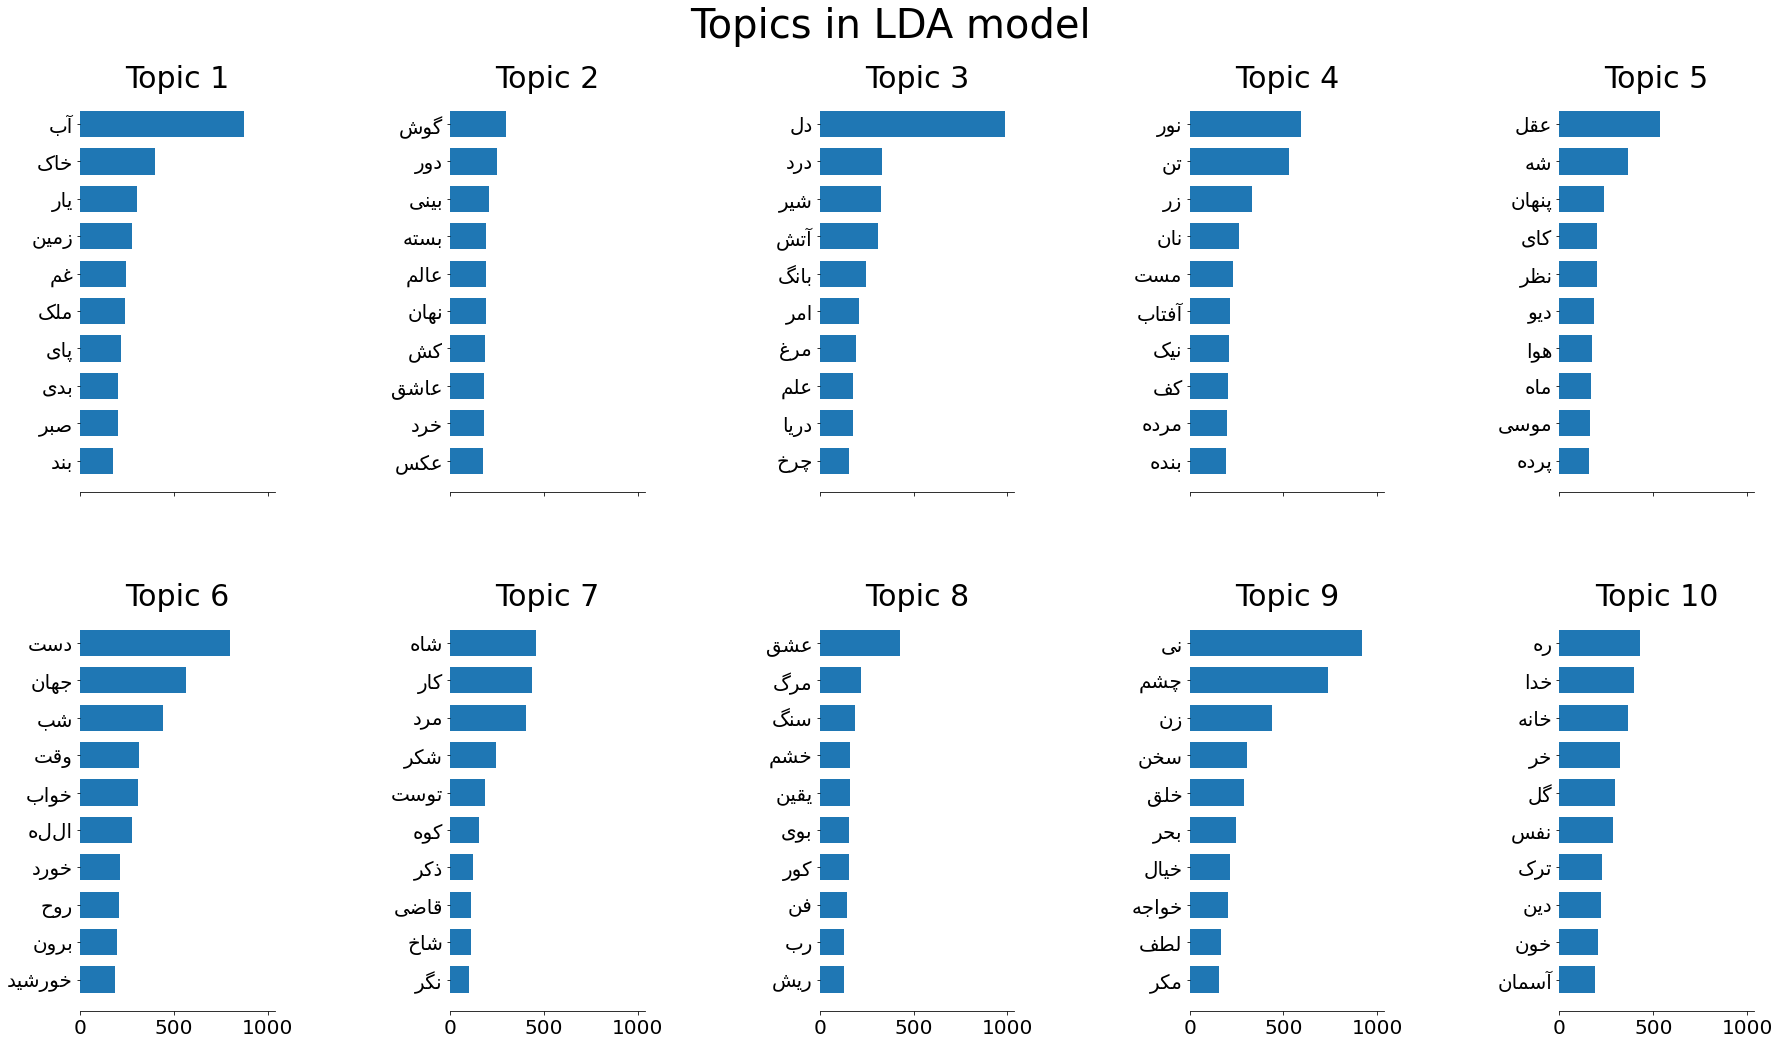

In [82]:
plot_top_words(lda, tf_feature_names, top_words, "Topics in LDA model")

### Plot frequent words by First Daftar

In [83]:
freq_df = pd.DataFrame(columns=['index', 'Freq', 'Daftar'])
for i in range(1,7):
    freq_dict = nltk.FreqDist(chain(*masnavi_df[masnavi_df['Daftar'] == i]['Couplet_tokenized']))
    freq_dict = pd.DataFrame.from_dict(freq_dict, orient='index', columns=['Freq'])
    freq_dict['Daftar'] = [i] * freq_dict.shape[0]
    freq_dict.reset_index(level=0, inplace=True)
    freq_dict['index'] = freq_dict['index'].apply(lambda x: make_farsi_text(x))
    freq_df = pd.concat([freq_df, freq_dict])

In [84]:
freq_df = freq_df[freq_df['Freq']> 100]

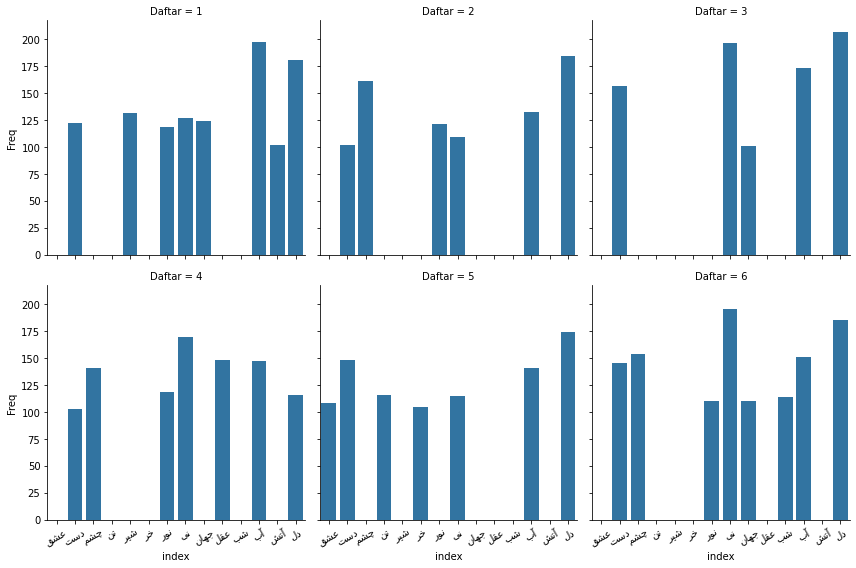

In [85]:
g = sns.FacetGrid(freq_df, col="Daftar", height=4, aspect=1, col_wrap=3)
g.set_xticklabels(rotation=30)
g.map(sns.barplot, "index", "Freq", order=list(set(freq_df['index'])))

### Topic Modeling of First Daftar

In [86]:
from gensim.test.utils import datapath
from pprint import pprint

In [87]:
dp_groups = masnavi_df.groupby(['Daftar'])

In [88]:
poems = []
for name, group in dp_groups:
    poems.append([t for l in group['Couplet_tokenized'] for t in l])

In [89]:
tf_vectorizer = CountVectorizer(
    max_df=0.95, min_df=2, max_features=10000
)

In [90]:
tf = tf_vectorizer.fit_transform(poems[1])

In [91]:
lda = LatentDirichletAllocation(
    n_components=10,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)

In [92]:
lda.fit(tf)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, random_state=0)

In [93]:
tf_feature_names = tf_vectorizer.get_feature_names_out()

In [94]:
tf_feature_names = [make_farsi_text(t) for t in tf_feature_names]

In [95]:
top_words = 10

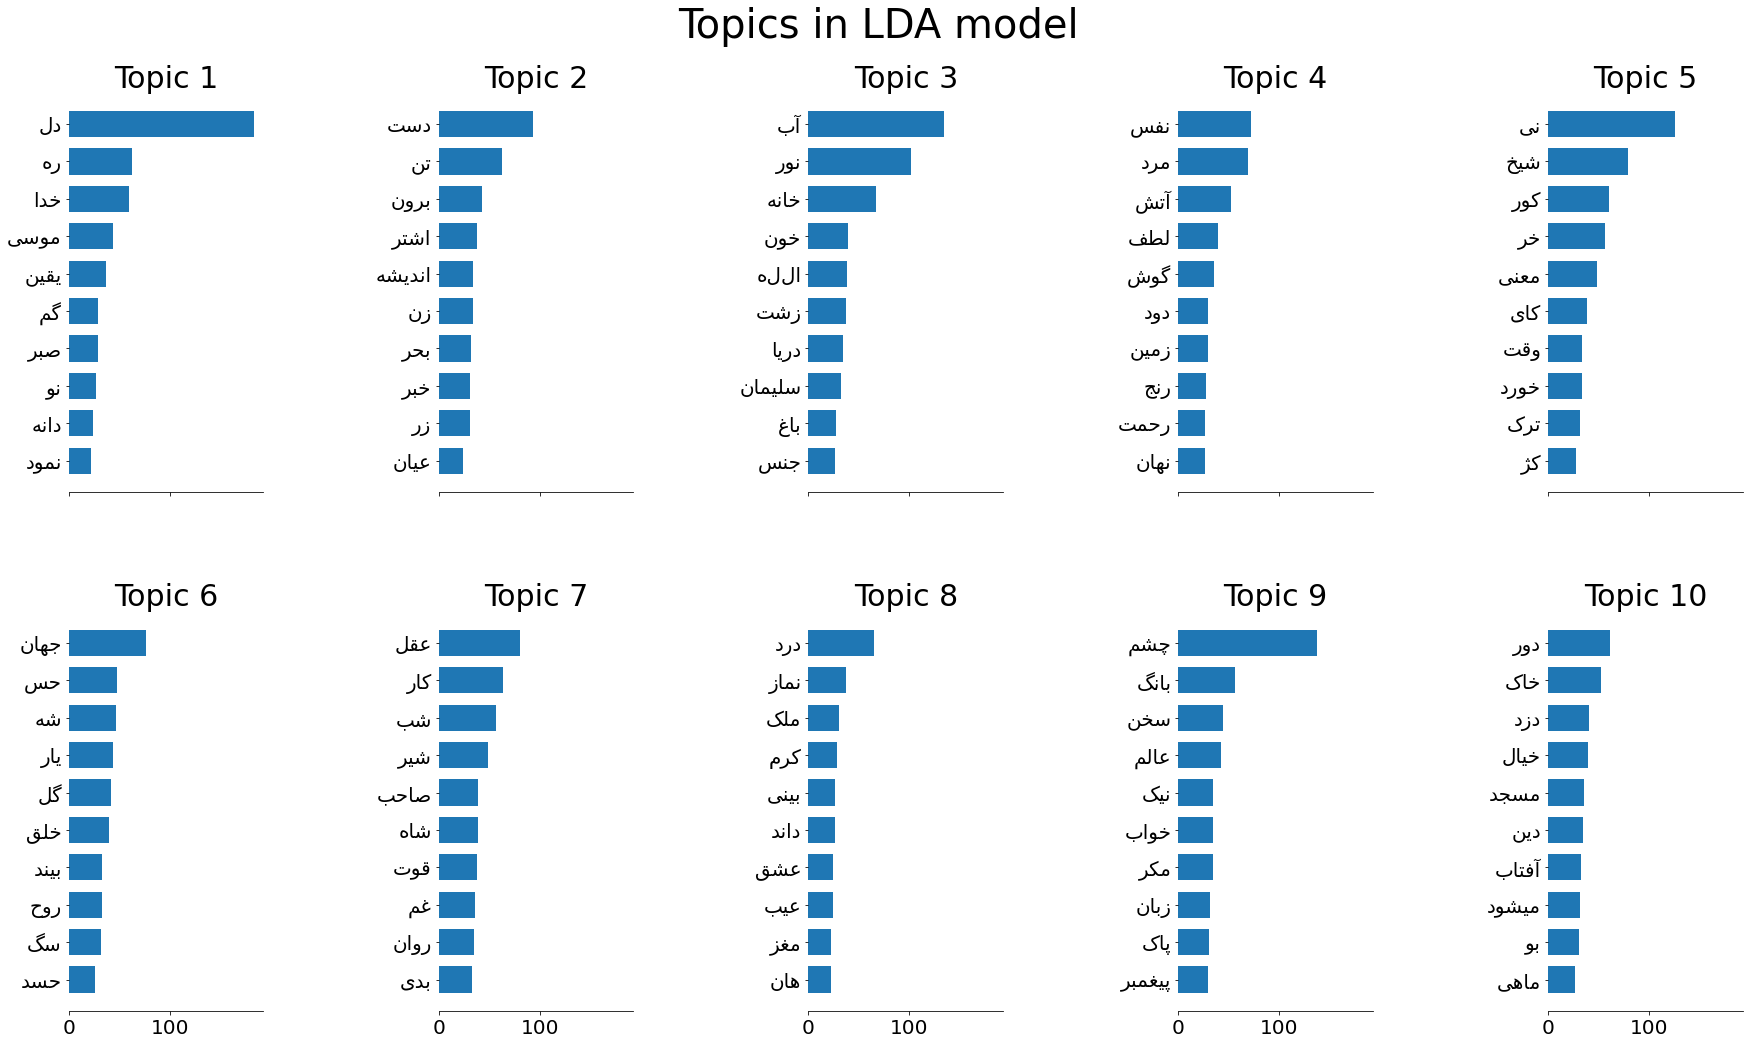

In [96]:
plot_top_words(lda, tf_feature_names, top_words, "Topics in LDA model")